# Import

In [2]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
import pandas as pd
import numpy as np

Matplotlib is building the font cache; this may take a moment.


In [3]:
merged_df = pd.read_csv('protein_expression.csv')
inputed_columns = ['AGID00215',
 'AGID00537',
 'AGID00536',
 'AGID00211',
 'AGID00485',
 'AGID00383',
 'AGID00216',
 'AGID00257',
 'AGID00545',
 'AGID00413',
 'AGID00547',
 'AGID00144']

In [4]:
protein_columns = merged_df.columns.drop(["ajcc_pathologic_stage","vital_status","days_to_death","days_to_last_follow_up","case_submitter_id"])
protein_columns

Index(['AGID00100', 'AGID00111', 'AGID00101', 'AGID00001', 'AGID00002',
       'AGID00003', 'AGID00443', 'AGID00120', 'AGID00004', 'AGID00005',
       ...
       'AGID00349', 'AGID02137', 'AGID00088', 'AGID00089', 'AGID00504',
       'AGID00095', 'AGID02217', 'AGID02210', 'AGID00326', 'AGID00432'],
      dtype='object', length=468)

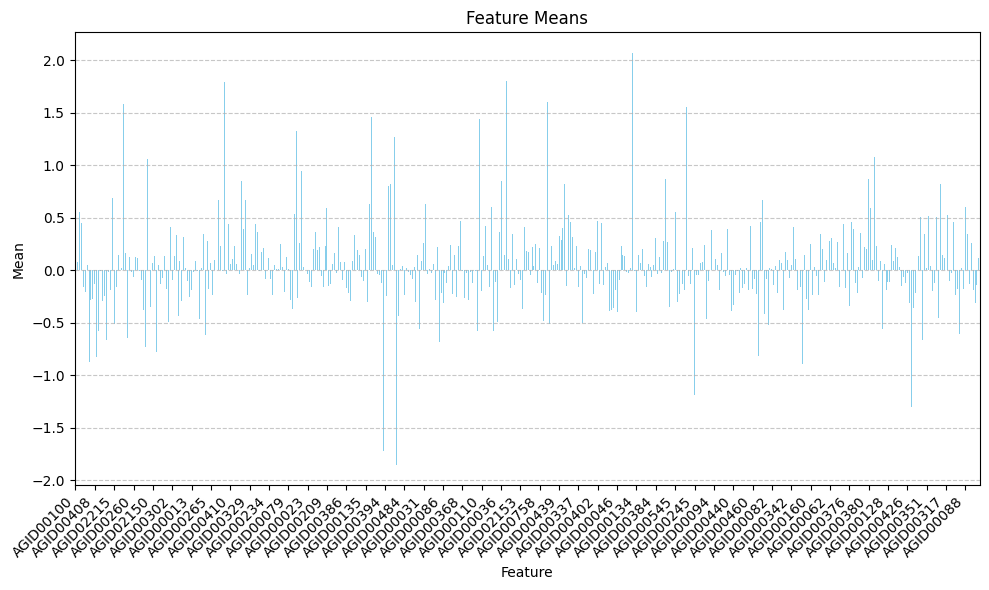

In [5]:
describe_df = merged_df[protein_columns].describe()
row_means = describe_df.loc['mean']

# Plot row means
plt.figure(figsize=(10, 6))
row_means.plot(kind='bar', color='skyblue')
plt.title('Feature Means')
plt.xlabel('Feature')
plt.ylabel('Mean')

plt.xticks(range(0, len(row_means), 10), row_means.index[::10], rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()


plt.show()

In [6]:
merged_df = merged_df.drop(["ajcc_pathologic_stage","vital_status","days_to_last_follow_up","case_submitter_id"], axis=1)
other = merged_df.columns.drop("days_to_death")

scaler = MinMaxScaler()
merged_df[other] = scaler.fit_transform(merged_df[other])

X_train, X_test, y_train, y_test = train_test_split(merged_df[other], merged_df["days_to_death"],
                                                    train_size=0.8,
                                                    random_state=1)

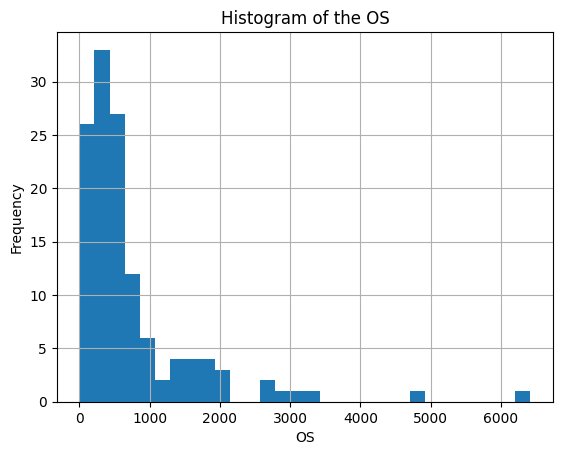

In [7]:
y_train.hist(bins=30) 
plt.xlabel('OS')
plt.ylabel('Frequency')
plt.title('Histogram of the OS')
plt.show()

# AE

In [26]:
class AE():
    def __init__(self,X_train,X_test,y_train,y_test,bottleneck,type):
        self.X_train = X_train
        self.X_test = X_test        
        self.y_train = y_train
        self.y_test = y_test
        self.bottleneck = bottleneck
        self.history = None
        self.encoder = None
        self.autoencoder = None
        self.type = type
        self.classifer = None

    def train(self):
    # Number of features in your dataset
        n_features = len(self.X_train.columns) 


        input_layer = Input(shape=(n_features,))
        encoder = Dense(64, activation='relu')(input_layer)
        encoder = Dense(32, activation='relu')(encoder)


        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(32, activation='relu')(bottleneck)
        decoder = Dense(64, activation='relu')(decoder)
        self.encoder= Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='adam', loss='mse')

        self.checkpoint = ModelCheckpoint(f'model/{self.type}_best_model.keras', 
                             monitor='val_loss', 
                             verbose=1,           
                             save_best_only=True, 
                             mode='min')         

        X_train, X_test= train_test_split(self.X_train,
                                                    train_size=0.8,
                                                    random_state=1)


        self.history = self.autoencoder.fit(X_train, X_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[self.checkpoint])  
        
        self.encode()
        self.map_y()

    def plot(self):
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss '+ self.type)
        plt.legend()
        plt.show()

    def encode(self):
        self.autoencoder.load_weights(f'model/{self.type}_best_model.keras')
        self.encoded_X_train = self.encoder.predict(self.X_train)
        self.encoded_X_test = self.encoder.predict(self.X_test)
    
    def do_PCA(self,n_components):
        if self.bottleneck == 2:
            # pca = PCA(n_components=n_components)
            # reduced_data = pca.fit_transform(self.encoded_X_test)
            x = self.encoded_X_test[:, 0]
            y = self.encoded_X_test[:, 1]
            plt.figure(figsize=(8, 6))
            scatter = plt.scatter(x, y, c=self.y_test_in_bin, cmap='viridis', alpha=0.7)
            plt.title('Encoded Data '+self.type)
            plt.xlabel('Encoded Dim 0')
            plt.ylabel('Encoded Dim 1')
            plt.colorbar(scatter, label='OS')
            plt.grid(True)
            plt.show()
            return
        if n_components ==2:
            pca = PCA(n_components=n_components)
            reduced_data = pca.fit_transform(self.encoded_X_test)
            x = reduced_data[:, 0]
            y = reduced_data[:, 1]
            plt.figure(figsize=(8, 6))
            scatter = plt.scatter(x, y, c=self.y_test_in_bin, cmap='viridis', alpha=0.7)
            plt.title('PCA of Encoded Data '+self.type)
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.colorbar(scatter, label='OS')
            plt.grid(True)
            plt.show()
        elif n_components ==3:
            pca = PCA(n_components=3)  # Reduce to 3 dimensions
            reduced_data = pca.fit_transform(self.encoded_X_test)
            x = reduced_data[:, 0]
            y = reduced_data[:, 1]
            z = reduced_data[:, 2]
            fig =plt.figure(figsize=(8, 6))
            ax = fig.add_subplot(111, projection='3d')
            scatter = ax.scatter(x, y, z, c=self.y_test_in_bin, cmap='viridis', depthshade=True)
            ax.set_title('3D PCA of Encoded Data '+self.type)
            ax.set_xlabel('Principal Component 1')
            ax.set_ylabel('Principal Component 2')
            ax.set_zlabel('Principal Component 3')
            plt.colorbar(scatter, label='OS')
            plt.show()

    @staticmethod
    def map_years_to_group(value):
        years = value / 365
        if years <= 1:
            return 0
        elif 1 < years <= 3:
            return 1
        elif 3 < years <= 5:
            return 2
        elif 5 < years <= 10:
            return 3
        elif 10 < years <= 20:
            return 4
        else:  
            return 5
        
    @staticmethod        
    def map_to_binary(category):
        if category >= 4:
            return 1
        else:  
            return 0
        
    def map_y(self):
        self.y_trian_in_category = self.y_train.map(AE.map_years_to_group)
        self.y_test_in_category = self.y_test.map(AE.map_years_to_group)        
        
        self.y_trian_in_bin = self.y_trian_in_category.map(AE.map_to_binary)
        self.y_test_in_bin = self.y_test_in_category.map(AE.map_to_binary)

    def cross_validation_model_selection(self,fold=10):
        classifiers = {
            'LogisticRegression': LogisticRegression(),
            'SVM': SVC(),
            'RandomForest': RandomForestClassifier(),
            'KNN': KNeighborsClassifier(),
            'GradientBoosting': GradientBoostingClassifier(),
            'AdaBoost': AdaBoostClassifier(),
            'NaiveBayes': GaussianNB(),
            'DecisionTree': DecisionTreeClassifier(),
            'ExtraTrees': ExtraTreesClassifier(),
            'XGBoost': xgb.XGBClassifier()
        }

        kf = KFold(n_splits=fold)
        best_cv_score = 0


        for name, clf in classifiers.items():
            cv_scores = []
            confusion_matrices = []

            for train_index, test_index in kf.split(self.encoded_X_train):
                X_train, X_test = self.encoded_X_train[train_index], self.encoded_X_train[test_index]
                y_train, y_test = self.y_trian_in_bin.iloc[train_index], self.y_trian_in_bin.iloc[test_index]

                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                
                cv_scores.append(accuracy_score(y_test, y_pred))
                confusion_matrices.append(confusion_matrix(y_test, y_pred))

            mean_cv_score = np.mean(cv_scores)
            mean_conf_matrix = np.mean(confusion_matrices, axis=0)

            print(f"{name} - Mean CV Score: {mean_cv_score}")
            print(f"{name} - Mean Confusion Matrix:\n{mean_conf_matrix}")

            if mean_cv_score > best_cv_score:
                best_cv_score = mean_cv_score
                best_classifier = name

        print(f"Best classifier: {best_classifier}, CV Score: {best_cv_score}")



    def cross_validation_hyperparameter_optimization(self,fold=5):
        pass


    def do_RF(self,binary):
        clf = RandomForestClassifier(n_estimators=100, random_state=0)

        if binary:
            clf.fit(self.encoded_X_train, self.y_trian_in_bin)
            y_pred = clf.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_bin, y_pred)
            print(classification_report(self.y_test_in_bin, y_pred))

        else:
            clf.fit(self.encoded_X_train, self.y_trian_in_category)
            y_pred = clf.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_category, y_pred)
            print(classification_report(self.y_test_in_category, y_pred))

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_pred), yticklabels=np.unique(self.y_test_in_bin))
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('RF Confusion Matrix '+self.type)
        plt.show()
        self.classifer = clf

    def do_Kmean(self):
        # Number of clusters - assuming you want as many as your known classes
        num_clusters = 2
        # Perform K-means clustering on the PCA output
        kmeans = KMeans(n_clusters=num_clusters, random_state=0)
        cluster_labels = kmeans.fit_predict(self.encoded_X_test)  # Use your 2D or 3D PCA-reduced data here


        print("Classification Report:")
        print(classification_report(self.y_test_in_bin, cluster_labels))
        conf_mat = confusion_matrix(self.y_test_in_bin, cluster_labels)

        # Plotting the confusion matrix
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_clusters), yticklabels=np.unique(self.y_test_in_bin))
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('K-mean Confusion Matrix '+self.type)
        plt.show()
        self.classifer = kmeans

    def do_SVM(self,binary):
        svm_classifier = SVC(kernel='linear',random_state=0)
        # Load the best weights into the autoencoder model
        if binary:
            svm_classifier.fit(self.encoded_X_train, self.y_trian_in_bin)
            y_pred = svm_classifier.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_bin, y_pred)
            print(classification_report(self.y_test_in_bin, y_pred))
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_pred), yticklabels=np.unique(self.y_test_in_bin))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('SVM Confusion Matrix '+ self.type)
            plt.show()
        else:
            svm_classifier.fit(self.encoded_X_train, self.y_trian_in_category)
            y_pred = svm_classifier.predict(self.encoded_X_test)
            cm = confusion_matrix(self.y_test_in_category, y_pred)
            print(classification_report(self.y_test_in_category, y_pred))
        
            # Plotting the confusion matrix
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_pred), yticklabels=np.unique(self.y_test_in_category))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('SVM Confusion Matrix '+ self.type)
            plt.show()
        self.classifer = svm_classifier





Epoch 1/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 431ms/step - loss: 0.0472
Epoch 1: val_loss improved from inf to 0.02995, saving model to model/(569 proteins encode to 6)_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0445 - val_loss: 0.0300
Epoch 2/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0261
Epoch 2: val_loss improved from 0.02995 to 0.02462, saving model to model/(569 proteins encode to 6)_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0246 - val_loss: 0.0246
Epoch 3/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0185
Epoch 3: val_loss improved from 0.02462 to 0.02389, saving model to model/(569 proteins encode to 6)_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0226 - val_loss: 0.0239
Epoch 4/100
 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0183
Epoch 4: val_loss improved from 0.02389 to 0.02371, saving model to model/(569 proteins encode to 6)_best_model.keras
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - los

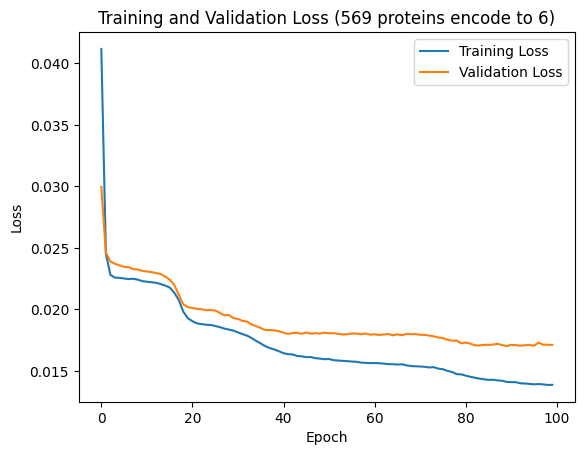

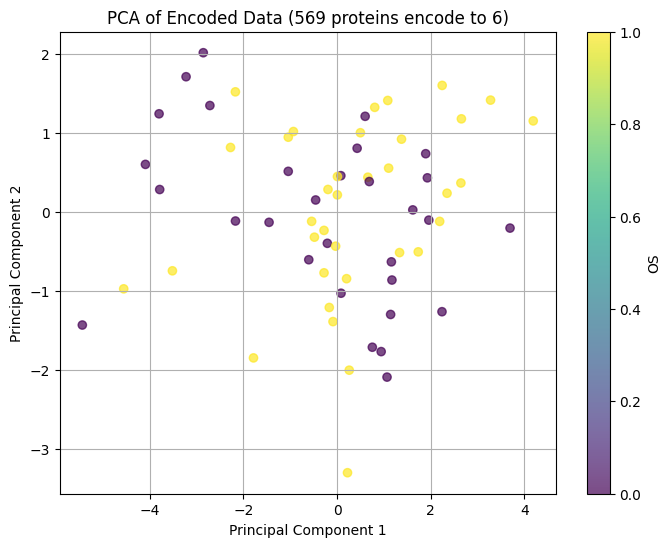

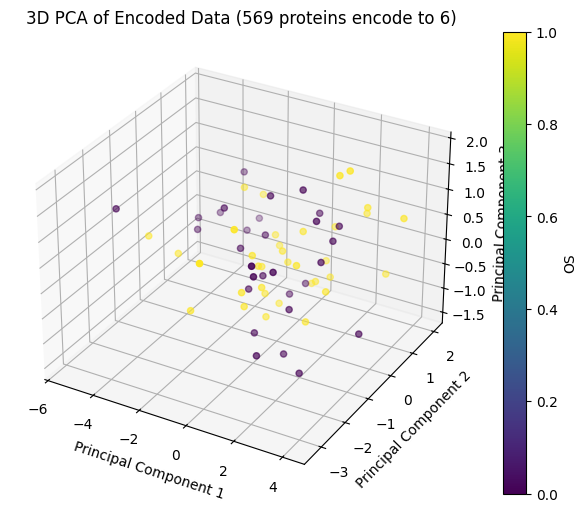

LogisticRegression - Mean CV Score: 0.5327692307692307
LogisticRegression - Mean Confusion Matrix:
[[6.1 6.5]
 [5.6 7.7]]
SVM - Mean CV Score: 0.556
SVM - Mean Confusion Matrix:
[[8.3 4.3]
 [7.2 6.1]]
RandomForest - Mean CV Score: 0.5438461538461539
RandomForest - Mean Confusion Matrix:
[[6.8 5.8]
 [6.  7.3]]
KNN - Mean CV Score: 0.5718461538461538
KNN - Mean Confusion Matrix:
[[7.3 5.3]
 [5.8 7.5]]
GradientBoosting - Mean CV Score: 0.544
GradientBoosting - Mean Confusion Matrix:
[[6.6 6. ]
 [5.8 7.5]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5172307692307692
AdaBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [7.  6.3]]
NaiveBayes - Mean CV Score: 0.5021538461538461
NaiveBayes - Mean Confusion Matrix:
[[ 0.6 12. ]
 [ 0.9 12.4]]
DecisionTree - Mean CV Score: 0.5675384615384615
DecisionTree - Mean Confusion Matrix:
[[6.8 5.8]
 [5.4 7.9]]
ExtraTrees - Mean CV Score: 0.5323076923076923
ExtraTrees - Mean Confusion Matrix:
[[6.5 6.1]
 [6.  7.3]]
XGBoost - Mean CV Score: 0.6092307692307692
XGBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [4.7 8.6]]
Best classifier: XGBoost, CV Score: 0.6092307692307692


In [27]:
AE_inputation = AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 6,type = "(569 proteins encode to 6)")
AE_inputation.train()
AE_inputation.plot()
AE_inputation.do_PCA(2)
AE_inputation.do_PCA(3)
AE_inputation.cross_validation_model_selection()

In [28]:
class Wider_AE(AE):
    def train(self):
    # Number of features in your dataset
        n_features = len(self.X_train.columns) 


        input_layer = Input(shape=(n_features,))
        encoder = Dense(256, activation='relu')(input_layer)

        encoder = Dense(128, activation='relu')(input_layer)
        encoder = Dense(64, activation='relu')(encoder)


        bottleneck = Dense(self.bottleneck, activation='relu')(encoder)  

        # Define the decoder (mirror the encoder)
        decoder = Dense(64, activation='relu')(bottleneck)
        decoder = Dense(128, activation='relu')(decoder)
        decoder = Dense(256, activation='relu')(decoder)

        self.encoder= Model(inputs=input_layer, outputs=bottleneck)

        # Output layer
        output_layer = Dense(n_features, activation='sigmoid')(decoder) 

        # Define the autoencoder model
        self.autoencoder = Model(inputs=input_layer, outputs=output_layer)

        # Compile the autoencoder
        self.autoencoder.compile(optimizer='adam', loss='mse')

        self.checkpoint = ModelCheckpoint(f'model/{self.type}_best_model.keras', 
                             monitor='val_loss', 
                             verbose=1,           
                             save_best_only=True, 
                             mode='min')         

        self.history = self.autoencoder.fit(self.X_train, self.X_train,
                epochs=100,
                batch_size=8,
                shuffle=True,
                validation_data=(self.X_test, self.X_test),
                callbacks=[self.checkpoint])  
        
        self.encode()
        self.map_y()       


Epoch 1/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 16s 512ms/step - loss: 0.0435
Epoch 1: val_loss improved from inf to 0.02378, saving model to model/(569 proteins encode to 12)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0364 - val_loss: 0.0238
Epoch 2/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0175
Epoch 2: val_loss improved from 0.02378 to 0.02247, saving model to model/(569 proteins encode to 12)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0227 - val_loss: 0.0225
Epoch 3/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0195
Epoch 3: val_loss improved from 0.02247 to 0.01974, saving model to model/(569 proteins encode to 12)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0208 - val_loss: 0.0197
Epoch 4/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0204
Epoch 4: val_loss improved from 0.01974 to 0.01900, saving model to model/(569 proteins encode to 12)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 

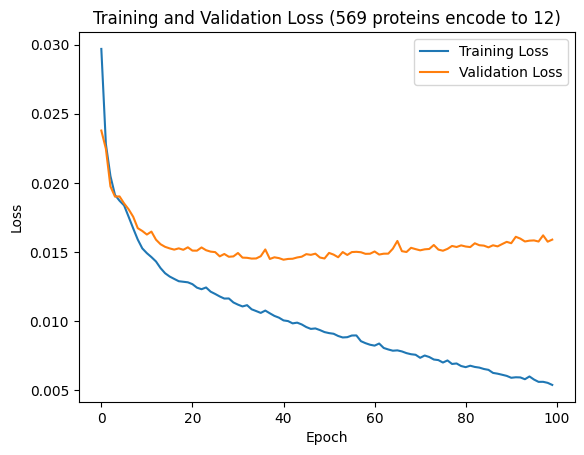

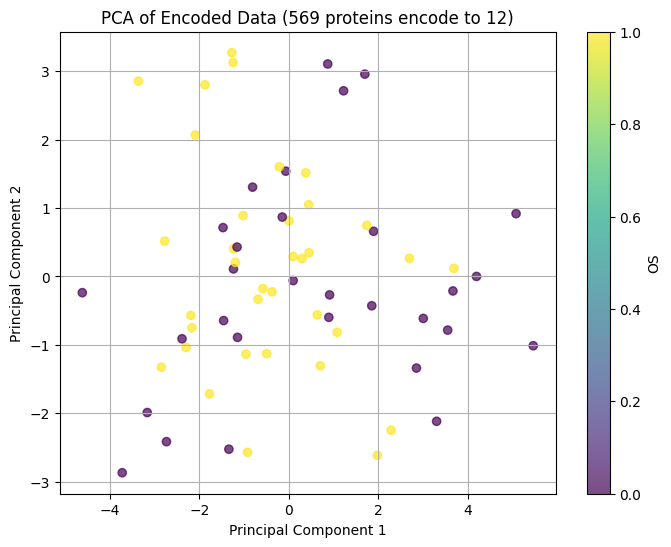

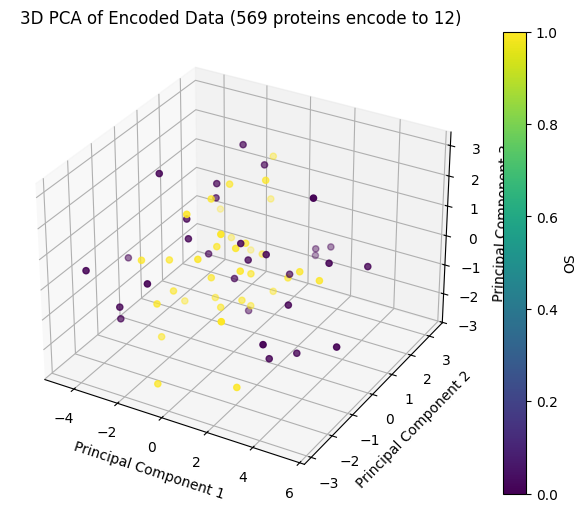

LogisticRegression - Mean CV Score: 0.548
LogisticRegression - Mean Confusion Matrix:
[[6.4 6.2]
 [5.5 7.8]]
SVM - Mean CV Score: 0.6370769230769231
SVM - Mean Confusion Matrix:
[[7.6 5. ]
 [4.4 8.9]]
RandomForest - Mean CV Score: 0.6215384615384615
RandomForest - Mean Confusion Matrix:
[[7.4 5.2]
 [4.6 8.7]]
KNN - Mean CV Score: 0.5676923076923076
KNN - Mean Confusion Matrix:
[[7.8 4.8]
 [6.4 6.9]]
GradientBoosting - Mean CV Score: 0.5676923076923076
GradientBoosting - Mean Confusion Matrix:
[[7.5 5.1]
 [6.1 7.2]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5906153846153845
AdaBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [5.2 8.1]]
NaiveBayes - Mean CV Score: 0.6098461538461539
NaiveBayes - Mean Confusion Matrix:
[[8.7 3.9]
 [6.2 7.1]]
DecisionTree - Mean CV Score: 0.5366153846153846
DecisionTree - Mean Confusion Matrix:
[[6.6 6. ]
 [6.  7.3]]
ExtraTrees - Mean CV Score: 0.5943076923076921
ExtraTrees - Mean Confusion Matrix:
[[7.2 5.4]
 [5.1 8.2]]
XGBoost - Mean CV Score: 0.5561538461538461
XGBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [6.  7.3]]
Best classifier: SVM, CV Score: 0.6370769230769231


In [29]:
WAE_inputation_12d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 12,type = "(569 proteins encode to 12)")
WAE_inputation_12d.train()
WAE_inputation_12d.plot()
WAE_inputation_12d.do_PCA(2)
WAE_inputation_12d.do_PCA(3)
WAE_inputation_12d.cross_validation_model_selection()



Epoch 1/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 15s 483ms/step - loss: 0.0434
Epoch 1: val_loss improved from inf to 0.02336, saving model to model/(569 proteins encode to 24)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0347 - val_loss: 0.0234
Epoch 2/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0226
Epoch 2: val_loss improved from 0.02336 to 0.02004, saving model to model/(569 proteins encode to 24)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0229 - val_loss: 0.0200
Epoch 3/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0216
Epoch 3: val_loss improved from 0.02004 to 0.01928, saving model to model/(569 proteins encode to 24)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0193 - val_loss: 0.0193
Epoch 4/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0240
Epoch 4: val_loss improved from 0.01928 to 0.01889, saving model to model/(569 proteins encode to 24)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - l

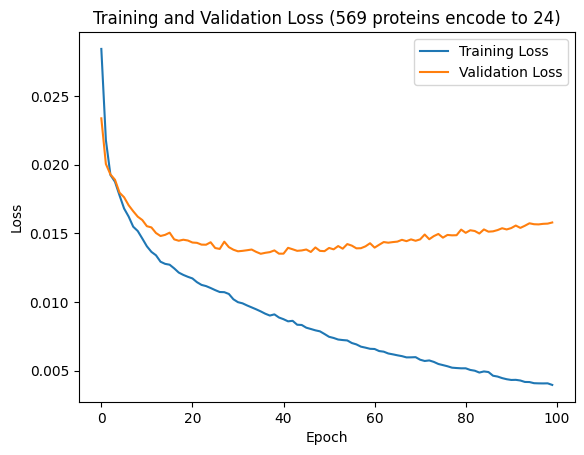

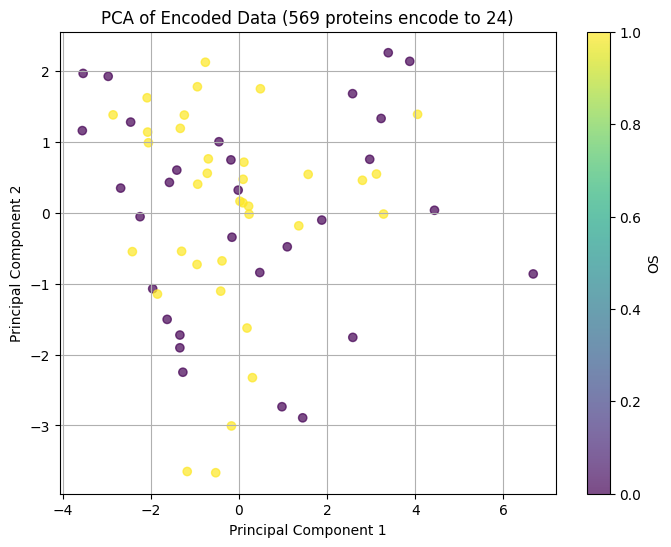

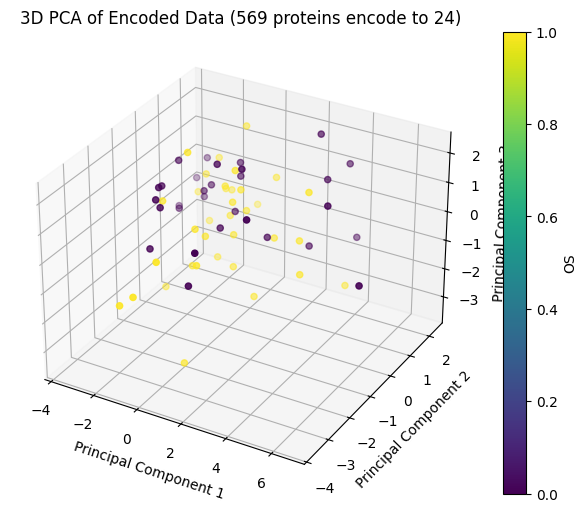

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

LogisticRegression - Mean CV Score: 0.6098461538461539
LogisticRegression - Mean Confusion Matrix:
[[7.6 5. ]
 [5.1 8.2]]
SVM - Mean CV Score: 0.6216923076923078
SVM - Mean Confusion Matrix:
[[7.4 5.2]
 [4.6 8.7]]
RandomForest - Mean CV Score: 0.570923076923077
RandomForest - Mean Confusion Matrix:
[[6.6 6. ]
 [5.1 8.2]]
KNN - Mean CV Score: 0.552153846153846
KNN - Mean Confusion Matrix:
[[6.9 5.7]
 [5.9 7.4]]
GradientBoosting - Mean CV Score: 0.5752307692307692
GradientBoosting - Mean Confusion Matrix:
[[7.  5.6]
 [5.4 7.9]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5786153846153848
AdaBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [5.6 7.7]]
NaiveBayes - Mean CV Score: 0.5747692307692309
NaiveBayes - Mean Confusion Matrix:
[[10.5  2.1]
 [ 8.9  4.4]]
DecisionTree - Mean CV Score: 0.5787692307692307
DecisionTree - Mean Confusion Matrix:
[[7.3 5.3]
 [5.6 7.7]]
ExtraTrees - Mean CV Score: 0.6021538461538463
ExtraTrees - Mean Confusion Matrix:
[[7.2 5.4]
 [4.9 8.4]]
XGBoost - Mean CV Score: 0.5826153846153845
XGBoost - Mean Confusion Matrix:
[[7.1 5.5]
 [5.3 8. ]]
Best classifier: SVM, CV Score: 0.6216923076923078


In [30]:
WAE_inputation_24d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 24,type = "(569 proteins encode to 24)")
WAE_inputation_24d.train()
WAE_inputation_24d.plot()
WAE_inputation_24d.do_PCA(2)
WAE_inputation_24d.do_PCA(3)
WAE_inputation_24d.cross_validation_model_selection()


Epoch 1/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 21s 657ms/step - loss: 0.0425
Epoch 1: val_loss improved from inf to 0.02415, saving model to model/(569 proteins encode to 28)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0356 - val_loss: 0.0241
Epoch 2/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0243
Epoch 2: val_loss improved from 0.02415 to 0.02277, saving model to model/(569 proteins encode to 28)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0230 - val_loss: 0.0228
Epoch 3/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0206
Epoch 3: val_loss improved from 0.02277 to 0.01957, saving model to model/(569 proteins encode to 28)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0216 - val_loss: 0.0196
Epoch 4/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0176
Epoch 4: val_loss improved from 0.01957 to 0.01899, saving model to model/(569 proteins encode to 28)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 

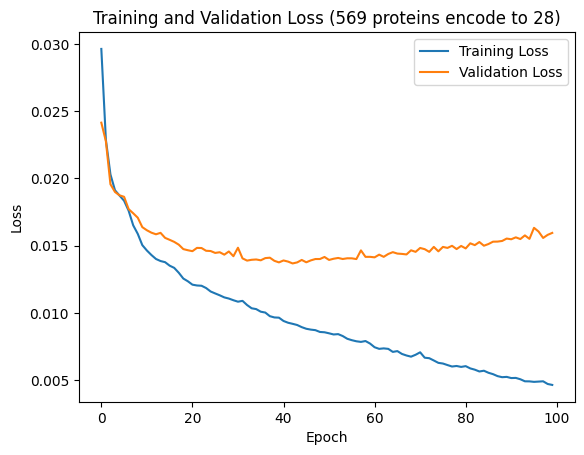

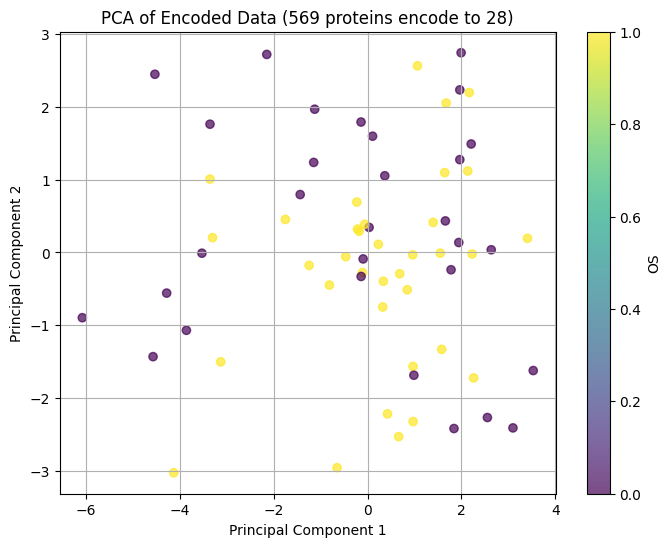

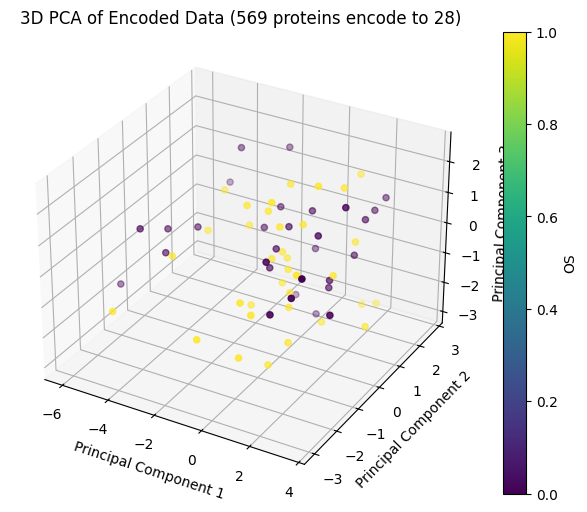

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

LogisticRegression - Mean CV Score: 0.556
LogisticRegression - Mean Confusion Matrix:
[[6.5 6.1]
 [5.4 7.9]]
SVM - Mean CV Score: 0.6021538461538463
SVM - Mean Confusion Matrix:
[[7.1 5.5]
 [4.8 8.5]]
RandomForest - Mean CV Score: 0.583076923076923
RandomForest - Mean Confusion Matrix:
[[6.5 6.1]
 [4.7 8.6]]
KNN - Mean CV Score: 0.5704615384615385
KNN - Mean Confusion Matrix:
[[8.  4.6]
 [6.5 6.8]]
GradientBoosting - Mean CV Score: 0.5635384615384614
GradientBoosting - Mean Confusion Matrix:
[[7.1 5.5]
 [5.8 7.5]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.571076923076923
AdaBoost - Mean Confusion Matrix:
[[6.9 5.7]
 [5.4 7.9]]
NaiveBayes - Mean CV Score: 0.5403076923076924
NaiveBayes - Mean Confusion Matrix:
[[12.   0.6]
 [11.3  2. ]]
DecisionTree - Mean CV Score: 0.5483076923076924
DecisionTree - Mean Confusion Matrix:
[[6.6 6. ]
 [5.7 7.6]]
ExtraTrees - Mean CV Score: 0.5870769230769229
ExtraTrees - Mean Confusion Matrix:
[[7.2 5.4]
 [5.3 8. ]]
XGBoost - Mean CV Score: 0.5712307692307691
XGBoost - Mean Confusion Matrix:
[[6.8 5.8]
 [5.3 8. ]]
Best classifier: SVM, CV Score: 0.6021538461538463


In [31]:
WAE_inputation_28d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 28,type = "(569 proteins encode to 28)")
WAE_inputation_28d.train()
WAE_inputation_28d.plot()
WAE_inputation_28d.do_PCA(2)
WAE_inputation_28d.do_PCA(3)
WAE_inputation_28d.cross_validation_model_selection()


Epoch 1/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 15s 477ms/step - loss: 0.0459
Epoch 1: val_loss improved from inf to 0.02412, saving model to model/(569 proteins encode to 18)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0359 - val_loss: 0.0241
Epoch 2/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0209
Epoch 2: val_loss improved from 0.02412 to 0.02197, saving model to model/(569 proteins encode to 18)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0228 - val_loss: 0.0220
Epoch 3/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0199
Epoch 3: val_loss improved from 0.02197 to 0.01924, saving model to model/(569 proteins encode to 18)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0205 - val_loss: 0.0192
Epoch 4/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0280
Epoch 4: val_loss improved from 0.01924 to 0.01910, saving model to model/(569 proteins encode to 18)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 

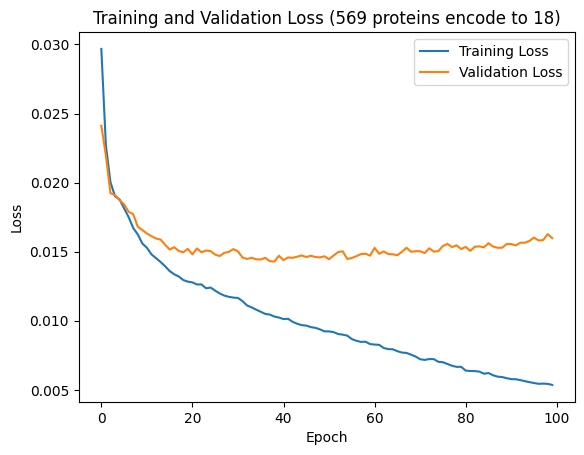

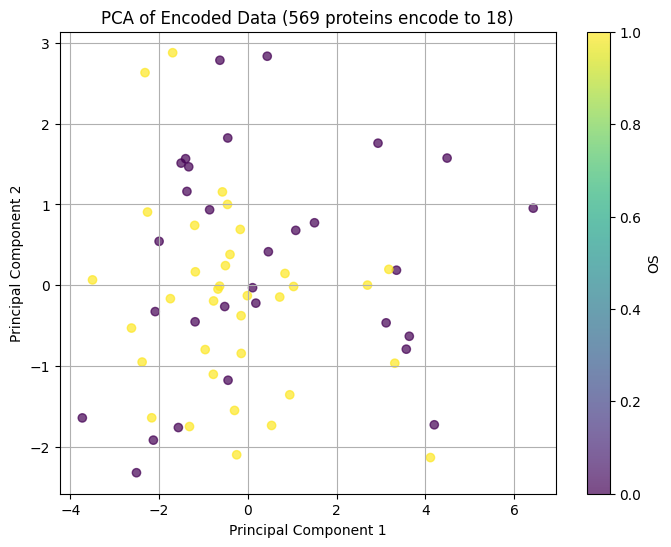

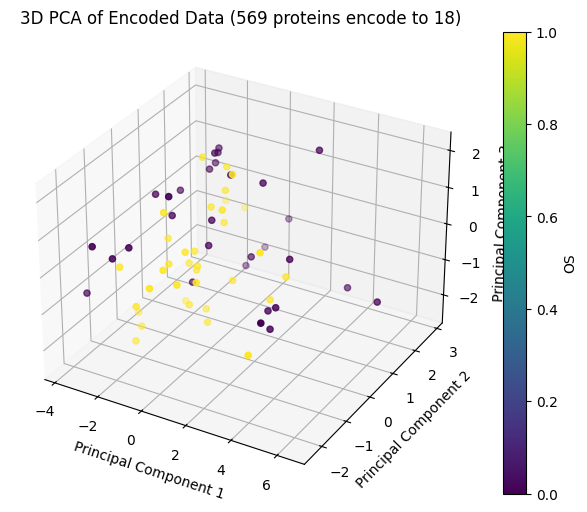

LogisticRegression - Mean CV Score: 0.5832307692307691
LogisticRegression - Mean Confusion Matrix:
[[7.  5.6]
 [5.2 8.1]]
SVM - Mean CV Score: 0.6100000000000001
SVM - Mean Confusion Matrix:
[[7.2 5.4]
 [4.7 8.6]]
RandomForest - Mean CV Score: 0.5713846153846154
RandomForest - Mean Confusion Matrix:
[[6.9 5.7]
 [5.4 7.9]]
KNN - Mean CV Score: 0.5598461538461539
KNN - Mean Confusion Matrix:
[[7.7 4.9]
 [6.5 6.8]]
GradientBoosting - Mean CV Score: 0.6260000000000001
GradientBoosting - Mean Confusion Matrix:
[[7.9 4.7]
 [5.  8.3]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5446153846153845
AdaBoost - Mean Confusion Matrix:
[[7.4 5.2]
 [6.6 6.7]]
NaiveBayes - Mean CV Score: 0.5869230769230768
NaiveBayes - Mean Confusion Matrix:
[[8.6 4. ]
 [6.7 6.6]]
DecisionTree - Mean CV Score: 0.5401538461538462
DecisionTree - Mean Confusion Matrix:
[[6.7 5.9]
 [6.  7.3]]
ExtraTrees - Mean CV Score: 0.6061538461538462
ExtraTrees - Mean Confusion Matrix:
[[7.5 5.1]
 [5.1 8.2]]
XGBoost - Mean CV Score: 0.5792307692307691
XGBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [5.5 7.8]]
Best classifier: GradientBoosting, CV Score: 0.6260000000000001


In [32]:
WAE_inputation_18d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 18,type = "(569 proteins encode to 18)")
WAE_inputation_18d.train()
WAE_inputation_18d.plot()
WAE_inputation_18d.do_PCA(2)
WAE_inputation_18d.do_PCA(3)
WAE_inputation_18d.cross_validation_model_selection()


Epoch 1/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 15s 495ms/step - loss: 0.0423
Epoch 1: val_loss improved from inf to 0.02486, saving model to model/(569 proteins encode to 28)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0350 - val_loss: 0.0249
Epoch 2/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0221
Epoch 2: val_loss improved from 0.02486 to 0.02161, saving model to model/(569 proteins encode to 28)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0227 - val_loss: 0.0216
Epoch 3/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0191
Epoch 3: val_loss improved from 0.02161 to 0.01937, saving model to model/(569 proteins encode to 28)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0196 - val_loss: 0.0194
Epoch 4/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0155
Epoch 4: val_loss improved from 0.01937 to 0.01897, saving model to model/(569 proteins encode to 28)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 

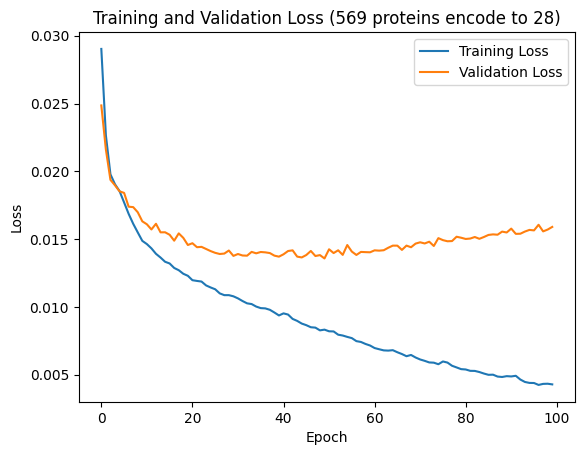

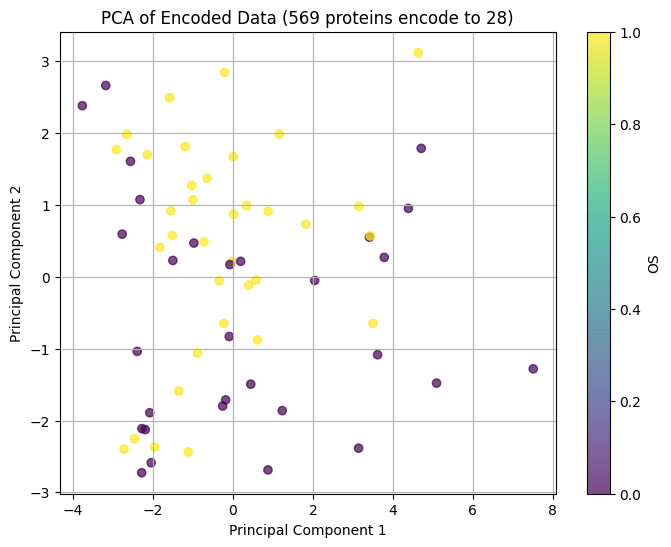

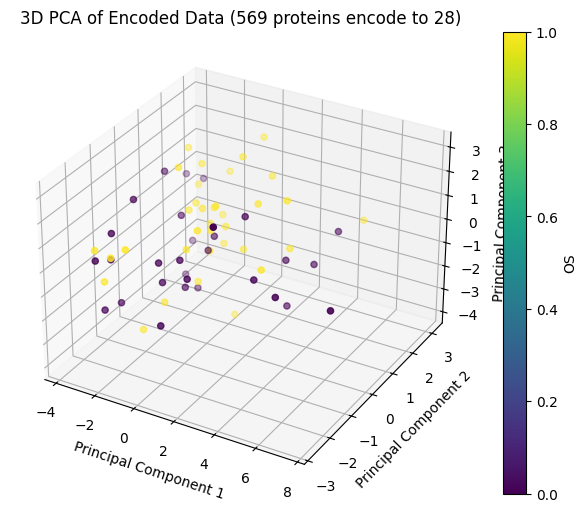

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

LogisticRegression - Mean CV Score: 0.5829230769230769
LogisticRegression - Mean Confusion Matrix:
[[6.9 5.7]
 [5.1 8.2]]
SVM - Mean CV Score: 0.6176923076923078
SVM - Mean Confusion Matrix:
[[7.2 5.4]
 [4.5 8.8]]
RandomForest - Mean CV Score: 0.6143076923076922
RandomForest - Mean Confusion Matrix:
[[7.2 5.4]
 [4.6 8.7]]
KNN - Mean CV Score: 0.6061538461538463
KNN - Mean Confusion Matrix:
[[8.1 4.5]
 [5.7 7.6]]
GradientBoosting - Mean CV Score: 0.61
GradientBoosting - Mean Confusion Matrix:
[[7.5 5.1]
 [5.  8.3]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6144615384615385
AdaBoost - Mean Confusion Matrix:
[[7.3 5.3]
 [4.7 8.6]]
NaiveBayes - Mean CV Score: 0.5481538461538461
NaiveBayes - Mean Confusion Matrix:
[[7.9 4.7]
 [7.  6.3]]
DecisionTree - Mean CV Score: 0.568
DecisionTree - Mean Confusion Matrix:
[[7.6 5. ]
 [6.2 7.1]]
ExtraTrees - Mean CV Score: 0.6603076923076923
ExtraTrees - Mean Confusion Matrix:
[[8.1 4.5]
 [4.3 9. ]]
XGBoost - Mean CV Score: 0.6141538461538463
XGBoost - Mean Confusion Matrix:
[[7.4 5.2]
 [4.8 8.5]]
Best classifier: ExtraTrees, CV Score: 0.6603076923076923


In [33]:
WAE_inputation_28d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 28,type = "(569 proteins encode to 28)")
WAE_inputation_28d.train()
WAE_inputation_28d.plot()
WAE_inputation_28d.do_PCA(2)
WAE_inputation_28d.do_PCA(3)
WAE_inputation_28d.cross_validation_model_selection()


Epoch 1/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 15s 484ms/step - loss: 0.0491
Epoch 1: val_loss improved from inf to 0.02372, saving model to model/(569 proteins encode to 48)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0368 - val_loss: 0.0237
Epoch 2/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0289
Epoch 2: val_loss improved from 0.02372 to 0.02235, saving model to model/(569 proteins encode to 48)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0240 - val_loss: 0.0224
Epoch 3/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0213
Epoch 3: val_loss improved from 0.02235 to 0.01960, saving model to model/(569 proteins encode to 48)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0205 - val_loss: 0.0196
Epoch 4/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0180
Epoch 4: val_loss improved from 0.01960 to 0.01907, saving model to model/(569 proteins encode to 48)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 

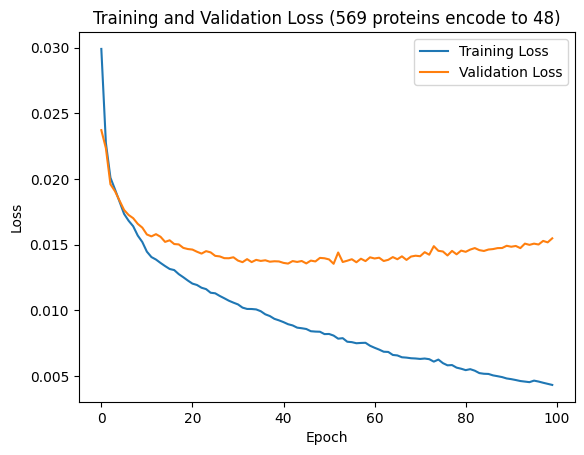

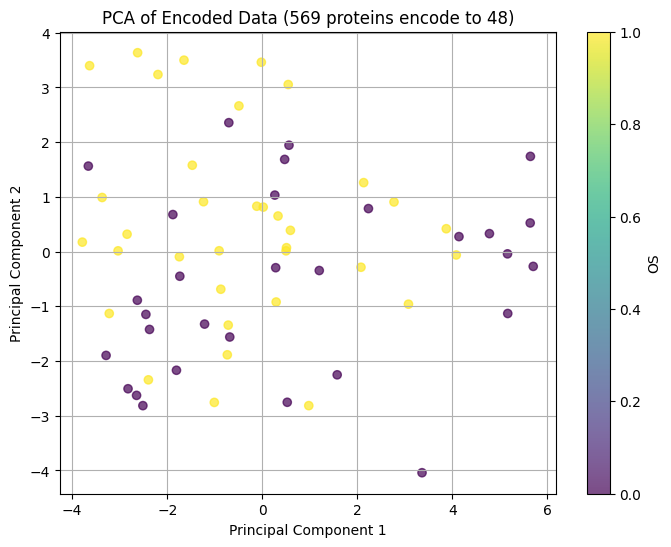

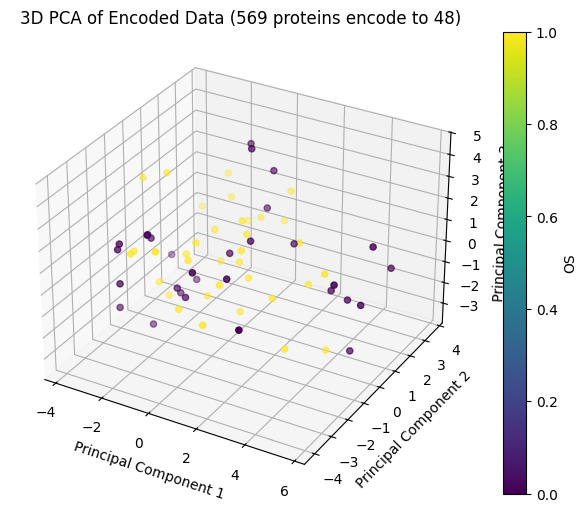

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

LogisticRegression - Mean CV Score: 0.6403076923076924
LogisticRegression - Mean Confusion Matrix:
[[8.  4.6]
 [4.7 8.6]]
SVM - Mean CV Score: 0.6255384615384616
SVM - Mean Confusion Matrix:
[[7.  5.6]
 [4.1 9.2]]
RandomForest - Mean CV Score: 0.6252307692307693
RandomForest - Mean Confusion Matrix:
[[7.4 5.2]
 [4.5 8.8]]
KNN - Mean CV Score: 0.6018461538461539
KNN - Mean Confusion Matrix:
[[7.9 4.7]
 [5.6 7.7]]
GradientBoosting - Mean CV Score: 0.6289230769230769
GradientBoosting - Mean Confusion Matrix:
[[8.  4.6]
 [5.  8.3]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6136923076923078
AdaBoost - Mean Confusion Matrix:
[[7.9 4.7]
 [5.3 8. ]]
NaiveBayes - Mean CV Score: 0.6290769230769231
NaiveBayes - Mean Confusion Matrix:
[[7.9 4.7]
 [4.9 8.4]]
DecisionTree - Mean CV Score: 0.5981538461538461
DecisionTree - Mean Confusion Matrix:
[[7.9 4.7]
 [5.7 7.6]]
ExtraTrees - Mean CV Score: 0.6250769230769231
ExtraTrees - Mean Confusion Matrix:
[[7.7 4.9]
 [4.8 8.5]]
XGBoost - Mean CV Score: 0.6133846153846154
XGBoost - Mean Confusion Matrix:
[[7.5 5.1]
 [4.9 8.4]]
Best classifier: LogisticRegression, CV Score: 0.6403076923076924


In [34]:
WAE_inputation_48d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 48,type = "(569 proteins encode to 48)")
WAE_inputation_48d.train()
WAE_inputation_48d.plot()
WAE_inputation_48d.do_PCA(2)
WAE_inputation_48d.do_PCA(3)
WAE_inputation_48d.cross_validation_model_selection()


Epoch 1/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 15s 477ms/step - loss: 0.0531
Epoch 1: val_loss improved from inf to 0.02347, saving model to model/(569 proteins encode to 36)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0373 - val_loss: 0.0235
Epoch 2/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0220
Epoch 2: val_loss improved from 0.02347 to 0.02113, saving model to model/(569 proteins encode to 36)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0221 - val_loss: 0.0211
Epoch 3/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0164
Epoch 3: val_loss improved from 0.02113 to 0.01966, saving model to model/(569 proteins encode to 36)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0188 - val_loss: 0.0197
Epoch 4/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0153
Epoch 4: val_loss improved from 0.01966 to 0.01881, saving model to model/(569 proteins encode to 36)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 

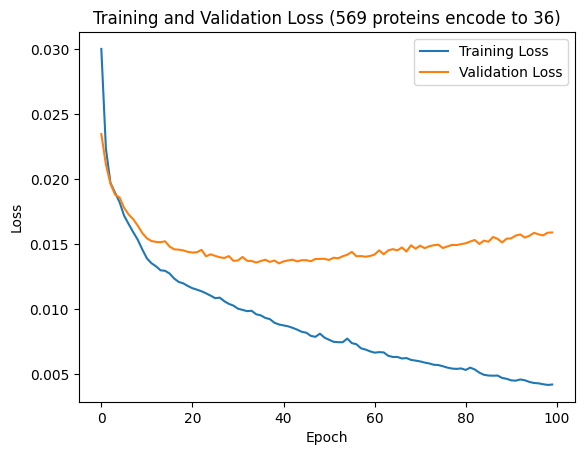

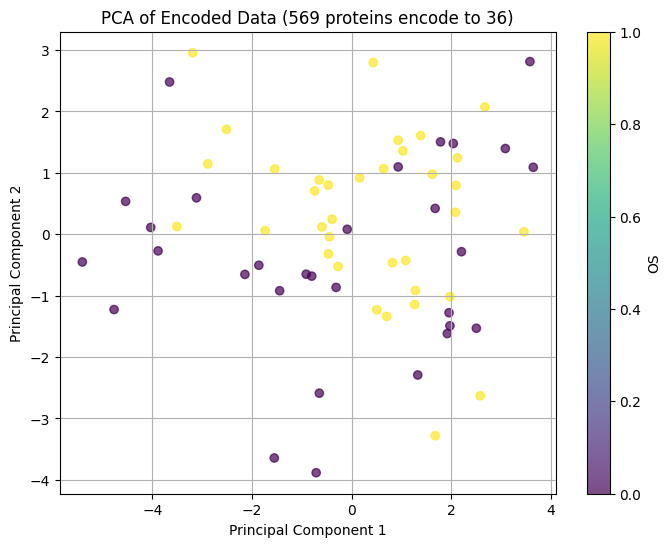

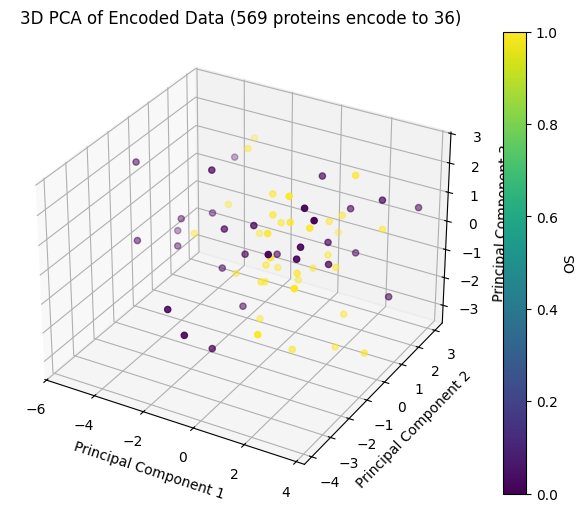

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

LogisticRegression - Mean CV Score: 0.5904615384615385
LogisticRegression - Mean Confusion Matrix:
[[6.7 5.9]
 [4.7 8.6]]
SVM - Mean CV Score: 0.6023076923076923
SVM - Mean Confusion Matrix:
[[6.8 5.8]
 [4.5 8.8]]
RandomForest - Mean CV Score: 0.6370769230769231
RandomForest - Mean Confusion Matrix:
[[7.6 5. ]
 [4.4 8.9]]
KNN - Mean CV Score: 0.6290769230769231
KNN - Mean Confusion Matrix:
[[8.5 4.1]
 [5.5 7.8]]
GradientBoosting - Mean CV Score: 0.6024615384615385
GradientBoosting - Mean Confusion Matrix:
[[7.  5.6]
 [4.7 8.6]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.5987692307692306
AdaBoost - Mean Confusion Matrix:
[[7.2 5.4]
 [5.  8.3]]
NaiveBayes - Mean CV Score: 0.5132307692307692
NaiveBayes - Mean Confusion Matrix:
[[12.2  0.4]
 [12.2  1.1]]
DecisionTree - Mean CV Score: 0.5438461538461539
DecisionTree - Mean Confusion Matrix:
[[6.5 6.1]
 [5.7 7.6]]
ExtraTrees - Mean CV Score: 0.6061538461538462
ExtraTrees - Mean Confusion Matrix:
[[7.  5.6]
 [4.6 8.7]]
XGBoost - Mean CV Score: 0.6060000000000001
XGBoost - Mean Confusion Matrix:
[[7.  5.6]
 [4.6 8.7]]
Best classifier: RandomForest, CV Score: 0.6370769230769231


In [35]:
WAE_inputation_36d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 36,type = "(569 proteins encode to 36)")
WAE_inputation_36d.train()
WAE_inputation_36d.plot()
WAE_inputation_36d.do_PCA(2)
WAE_inputation_36d.do_PCA(3)
WAE_inputation_36d.cross_validation_model_selection()


Epoch 1/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 15s 499ms/step - loss: 0.0447
Epoch 1: val_loss improved from inf to 0.02364, saving model to model/(569 proteins encode to 28)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0355 - val_loss: 0.0236
Epoch 2/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0264
Epoch 2: val_loss improved from 0.02364 to 0.02201, saving model to model/(569 proteins encode to 28)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0233 - val_loss: 0.0220
Epoch 3/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0204
Epoch 3: val_loss improved from 0.02201 to 0.01933, saving model to model/(569 proteins encode to 28)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0210 - val_loss: 0.0193
Epoch 4/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0212
Epoch 4: val_loss improved from 0.01933 to 0.01898, saving model to model/(569 proteins encode to 28)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

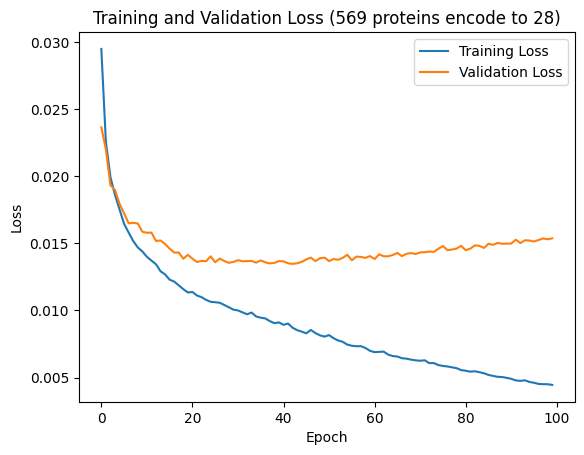

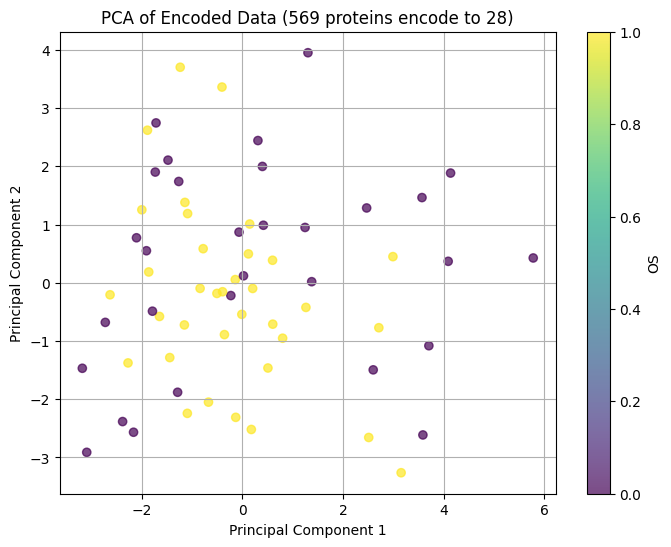

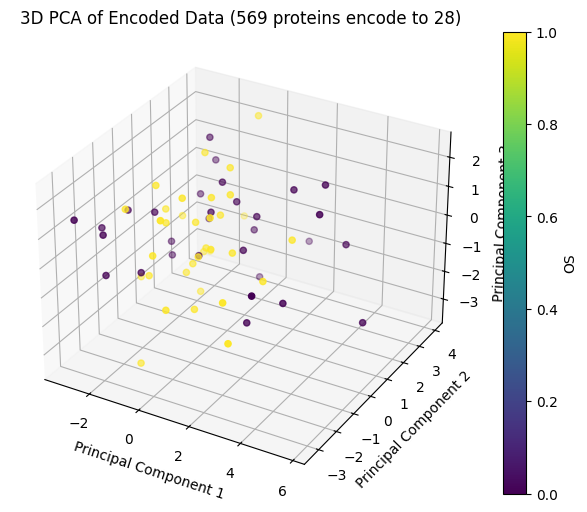

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

LogisticRegression - Mean CV Score: 0.5366153846153846
LogisticRegression - Mean Confusion Matrix:
[[6.1 6.5]
 [5.5 7.8]]
SVM - Mean CV Score: 0.5793846153846154
SVM - Mean Confusion Matrix:
[[6.6 6. ]
 [4.9 8.4]]
RandomForest - Mean CV Score: 0.6252307692307693
RandomForest - Mean Confusion Matrix:
[[7.4 5.2]
 [4.5 8.8]]
KNN - Mean CV Score: 0.6524615384615384
KNN - Mean Confusion Matrix:
[[8.2 4.4]
 [4.6 8.7]]
GradientBoosting - Mean CV Score: 0.6023076923076922
GradientBoosting - Mean Confusion Matrix:
[[7.5 5.1]
 [5.2 8.1]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.583076923076923
AdaBoost - Mean Confusion Matrix:
[[7.5 5.1]
 [5.7 7.6]]
NaiveBayes - Mean CV Score: 0.5787692307692307
NaiveBayes - Mean Confusion Matrix:
[[8.1 4.5]
 [6.4 6.9]]
DecisionTree - Mean CV Score: 0.5630769230769231
DecisionTree - Mean Confusion Matrix:
[[6.5 6.1]
 [5.2 8.1]]
ExtraTrees - Mean CV Score: 0.6409230769230769
ExtraTrees - Mean Confusion Matrix:
[[7.7 4.9]
 [4.4 8.9]]
XGBoost - Mean CV Score: 0.6524615384615384
XGBoost - Mean Confusion Matrix:
[[7.8 4.8]
 [4.2 9.1]]
Best classifier: KNN, CV Score: 0.6524615384615384


In [36]:
WAE_inputation_28d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 28,type = "(569 proteins encode to 28)")
WAE_inputation_28d.train()
WAE_inputation_28d.plot()
WAE_inputation_28d.do_PCA(2)
WAE_inputation_28d.do_PCA(3)
WAE_inputation_28d.cross_validation_model_selection()


Epoch 1/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 15s 480ms/step - loss: 0.0420
Epoch 1: val_loss improved from inf to 0.02402, saving model to model/(569 proteins encode to 34)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0352 - val_loss: 0.0240
Epoch 2/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0268
Epoch 2: val_loss improved from 0.02402 to 0.02052, saving model to model/(569 proteins encode to 34)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0224 - val_loss: 0.0205
Epoch 3/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0186
Epoch 3: val_loss improved from 0.02052 to 0.01916, saving model to model/(569 proteins encode to 34)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0199 - val_loss: 0.0192
Epoch 4/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0193
Epoch 4: val_loss improved from 0.01916 to 0.01895, saving model to model/(569 proteins encode to 34)_best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

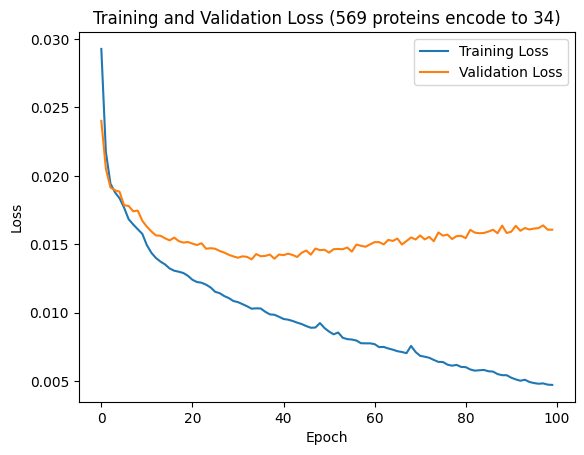

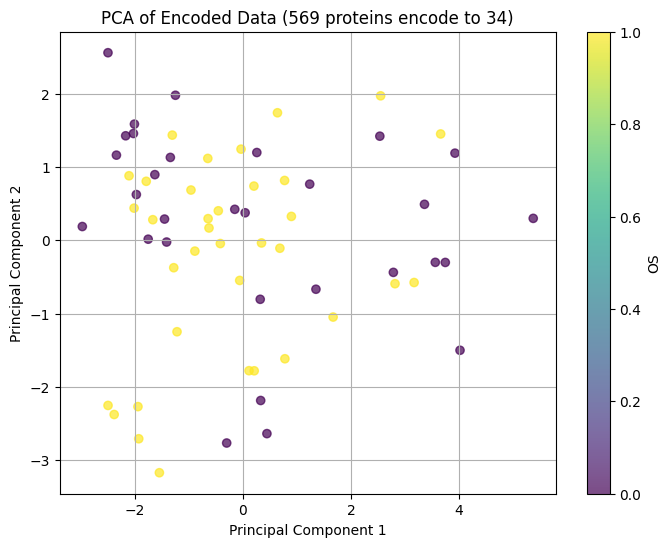

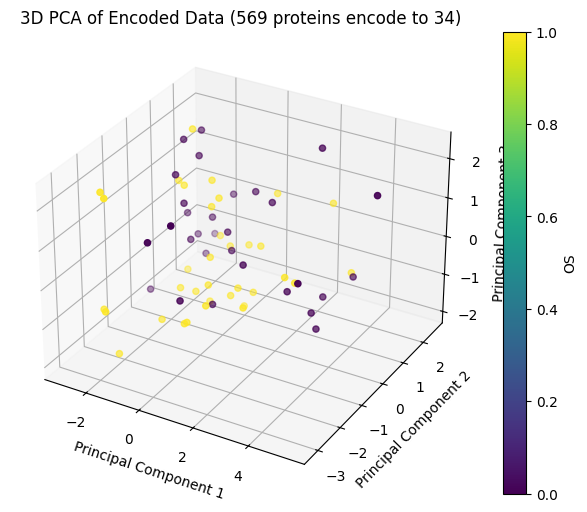

/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

LogisticRegression - Mean CV Score: 0.5906153846153848
LogisticRegression - Mean Confusion Matrix:
[[6.9 5.7]
 [4.9 8.4]]
SVM - Mean CV Score: 0.6023076923076923
SVM - Mean Confusion Matrix:
[[7.1 5.5]
 [4.8 8.5]]
RandomForest - Mean CV Score: 0.6449230769230769
RandomForest - Mean Confusion Matrix:
[[7.4 5.2]
 [4.  9.3]]
KNN - Mean CV Score: 0.5944615384615386
KNN - Mean Confusion Matrix:
[[7.4 5.2]
 [5.3 8. ]]
GradientBoosting - Mean CV Score: 0.6444615384615384
GradientBoosting - Mean Confusion Matrix:
[[8.1 4.5]
 [4.7 8.6]]


/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/HSAE/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent thi

AdaBoost - Mean CV Score: 0.6447692307692308
AdaBoost - Mean Confusion Matrix:
[[7.6 5. ]
 [4.2 9.1]]
NaiveBayes - Mean CV Score: 0.5830769230769229
NaiveBayes - Mean Confusion Matrix:
[[6.5 6.1]
 [4.7 8.6]]
DecisionTree - Mean CV Score: 0.6092307692307692
DecisionTree - Mean Confusion Matrix:
[[7.8 4.8]
 [5.3 8. ]]
ExtraTrees - Mean CV Score: 0.6252307692307693
ExtraTrees - Mean Confusion Matrix:
[[7.6 5. ]
 [4.7 8.6]]
XGBoost - Mean CV Score: 0.6796923076923076
XGBoost - Mean Confusion Matrix:
[[8.3 4.3]
 [4.  9.3]]
Best classifier: XGBoost, CV Score: 0.6796923076923076


In [37]:
WAE_inputation_34d = Wider_AE(X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test,bottleneck = 34,type = "(569 proteins encode to 34)")
WAE_inputation_34d.train()
WAE_inputation_34d.plot()
WAE_inputation_34d.do_PCA(2)
WAE_inputation_34d.do_PCA(3)
WAE_inputation_34d.cross_validation_model_selection()


# Resources Investigation:

ICGC:
https://dcc.icgc.org/repositories?filters=%7B%22file%22:%7B%20%22projectCode%22:%7B%22is%22:%5B%22HNSC-US%22%5D%7D%7D%7D

 Data Type
 SSM  2,126
 Aligned Reads  2,037
 Clinical Data  453
 Biospecimen Data  448
 StSM  223
 SGV  132
 CNSM  88
 StGV  88

TCPA:
https://www.tcpaportal.org/tcpa/download.html

TCGA of 2018, with L4(normalized across RPPA batches therefore enable pan-cancer)

PDC:
https://proteomic.datacommons.cancer.gov/pdc/browse
3 studies, but Mass Spectrum not RPPA, therefore only contains Peptide result. do have clinincal though

HNSCC PDX: 
https://aacrjournals.org/mcr/article/14/3/278/89624/Proteomic-Characterization-of-Head-and-Neck-Cancer
RPPA, but on mention how to acess and probabaly wound not have clinical since the read from transplated rats.

HAP: Reference RNA and protein from healthy samples:
https://www.proteinatlas.org/about/download

Pride:Full MS sets
https://www.ebi.ac.uk/pride/archive?keyword=HNSCC,RPPA&sortDirection=DESC&page=0&pageSize=20

Paper HNSCC: RPPA but only target 60 specific protein
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3070553/

GEO: Some Protein profiling by protein array (RPPA), no HNSCC
https://www.ncbi.nlm.nih.gov/geo/browse/

ArraryExpress: RPPA for GBM, lung cancer, breast cancer
https://www.ebi.ac.uk/biostudies/arrayexpress/studies?query=RPPA

FANTOM6 Experiment Index: RNA-Seq
https://fantom.gsc.riken.jp/6/experiment_index/#/

Resources index: 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6971871/